In [1]:
import glob
from matplotlib import image 
from matplotlib import pyplot as plt
from PIL import Image
import os
import cv2 as cv
import numpy as np
import scipy.io
import random
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
import math

1.Downloading the data and Undersatnding it

In [2]:
!wget -q {"http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"}
!tar -xzf /content/BSR_bsds500.tgz


'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open '/content/BSR_bsds500.tgz'


In [3]:
# Creating the output directory
!mkdir '/content/output'
!mkdir '/content/output/Ground-Truth'
!mkdir '/content/output/Result'


The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.


In [4]:
#saving output
directory = "content"
    
# Parent Directory path
parent_dir = "."

# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'output' directory to save all outputs inside
directory = "output"
    
# Parent Directory path
parent_dir = "./content"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'Ground Truth' directory
directory = "Ground-Truth"
    
# Parent Directory path
parent_dir = "./content/output"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'Ground Truth' directory
directory = "Result"
    
# Parent Directory path
parent_dir = "./content/output"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)    

In [5]:
#Get the images for training
training_images = sorted(glob.glob("BSR/BSDS500/data/images/train/**/*.jpg", recursive=True))

#Get the images for testing
testing_images = sorted(glob.glob("BSR/BSDS500/data/images/test/**/*.jpg", recursive=True))
testing_images = testing_images[0:50]

#Get the ground-truth for training
ground_truth_training = sorted(glob.glob("BSR/BSDS500/data/groundTruth/train/**/*.mat", recursive=True))

#Get the ground-truth for testing
ground_truth_testing = sorted(glob.glob("BSR/BSDS500/data/groundTruth/test/**/*.mat", recursive=True))
ground_truth_testing = ground_truth_testing[0:50]

In [6]:
# Loading images
testing_data = []
for path in testing_images:
    img = image.imread(path)
    testing_data.append(img)

In [7]:
testing_data[0].shape

(321, 481, 3)

In [8]:
testing_data[0].reshape((-1,3)).shape

(154401, 3)

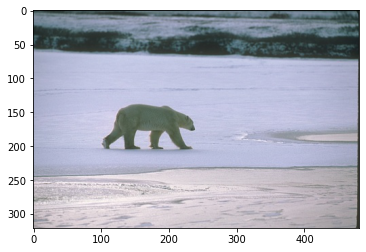

In [61]:
plt.imshow(testing_data[0])
plt.show()


2.Visualize the image and the ground truth segmentation


In [9]:
def ground_truth_images_func(index,dataset):
  ground_truth_image = scipy.io.loadmat(dataset[index])
  ground_truth_image = np.squeeze(ground_truth_image['groundTruth'])
 # print(ground_truth_image)
  #print(ground_truth_image.shape)
  # print(len(ground_truth_image))
  
  ground_truth_images = [] #making a list for the ground truth images 
  number_of_ground_truths = len(ground_truth_image)
  for i in range(number_of_ground_truths):
    current_ground_truth = ground_truth_image[i][0][0][0]
    ground_truth_images.append(current_ground_truth)
  return ground_truth_images


In [10]:
def read_image(index, dataset):
  path='./content/output/Ground-Truth'  #output is saved here
  file_name = str(dataset).lower() + ' ' + str(index) + ' visualization' #file name
  fig, axarr = plt.subplots(2,3, figsize = (8, 8))

  if dataset == "TRAIN":
    normal_dataset = training_images
    ground_truth_dataset = ground_truth_training
  if dataset == "TEST":
    normal_dataset = testing_images
    ground_truth_dataset = ground_truth_testing
  #if dataset == "predection_images":  

  #creating an empty list of images
  images = []  
  normal_image = image.imread(normal_dataset[index])
  images.append(normal_image)
  ground_truth_images = ground_truth_images_func(index,  ground_truth_dataset) # Getting the ground truth of the image
  images = images + ground_truth_images  # to display all
  #looping through the images list to show the image
  for i in range(len(images)):
    row = i // 3
    col = i % 3
    if i == 0:
      axarr[row][col].imshow(images[0])
    axarr[i // 3][i % 3].imshow(images[i], interpolation='nearest')
  fig.suptitle(file_name, fontsize=16)
  plt.savefig(os.path.join(path, file_name), bbox_inches = 'tight')
  plt.show()


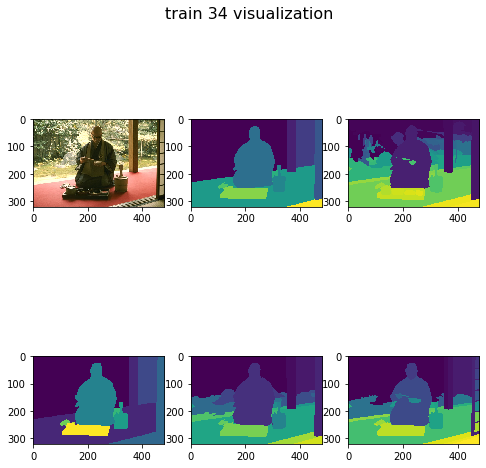

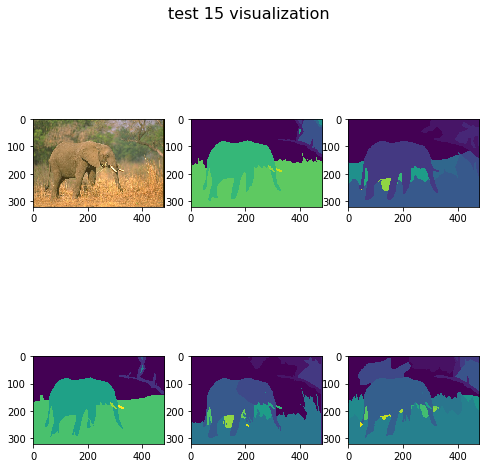

In [11]:

datasets = ["TRAIN", "TEST"]
random_images = random.sample(range(0, 50), 2) # Calling the above function to get 2 random images to visualize

# Visualize a sample from training dataset and a sample from test data set alternatively
for i in range(len(random_images)):
    read_image(random_images[i], datasets[i & 1])

In [12]:
'''# For the comparison part
f = []
for i in range(len(random_images)):
  f.append(ground_truth_images_func(random_images[i], datasets[i & 1]))'''

'# For the comparison part\nf = []\nfor i in range(len(random_images)):\n  f.append(ground_truth_images_func(random_images[i], datasets[i & 1]))'

In [13]:
'''from google.colab import files
!zip -qq -r /content/output.zip /content/output
files.download("/content/output.zip")'''

'from google.colab import files\n!zip -qq -r /content/output.zip /content/output\nfiles.download("/content/output.zip")'

K-means implementation

In [14]:
K_range= [3,5,7,9,11]


In [15]:
def plot_img_seg(img, seg, k):
    figure_size = 15
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,1),plt.imshow(img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(seg)
    plt.title('Segmented Image when K = %i' % k), plt.xticks([]), plt.yticks([])
    plt.show()

In [16]:
def kmean_f(img, k):
    feature = img.reshape((-1, 3))
    km = KMeans(n_clusters=k)
    km.fit(feature)
    seg = km.predict(feature)
    seg = seg.reshape((img[:, :, 0].shape))
    return seg

In [17]:
print(testing_data[0].shape)

(321, 481, 3)


In [18]:
path='./content/output/Result'
ind_name = 0
pred_img = []
for test_img in testing_data:
    image_list = []
    fig, axarr = plt.subplots(2,3, figsize = (15, 15))
    file_name = 'img_' + str(ind_name)
    image_list.append(test_img)
    for k in K_range:
        image_list.append(kmean_f(test_img, k))
    pred_img.append(image_list[1:])
    for i in range(len(image_list)):
        row = i // 3
        col = i % 3
        if i == 0:
            axarr[row][col].imshow(image_list[0])
        axarr[i // 3][i % 3].imshow(image_list[i], interpolation='nearest')
    
    fig.suptitle(file_name, fontsize=16)
    plt.savefig(os.path.join(path, file_name), bbox_inches = 'tight')
    plt.close(fig)
    ind_name += 1 

F-measure and Conditional Entropy



In [19]:
def sizeOfIntersection(cluster, truth):
  size=0
  n=len(cluster)
  for i in range(n):
    if(cluster[i] in truth):
      size+=1
  return size

In [20]:
# def Purity(clusters, truths, numElements):
#   purity=0 
#   k=len(clusters)
#   results = np.zeros((k,2), dtype=object)

#   for i in range(k):
#     max= -1
#     for j in range(len(truths)):
#       temp=sizeOfIntersection(clusters[i], truths[j])
#       if(temp>max):
#         max=temp
#         max_T=j
#     results[i][0]=max_T #index of best matching class
#     results[i][1]=max   #number elements matched from best matching class

#   #Calculate Purity
#   purity_i = np.zeros(k)
#   for i in range(k):
#     purity_i[i]=results[i][1]/len(clusters[i])
#     purity+=purity_i[i]*len(clusters[i])/numElements
#   return results,purity_i, purity
# def FMeasure(clusters, truths, numElements):
#   results,prec, purity = Purity(clusters, truths, numElements)
#   F=0
#   k=len(clusters)

#   #Calculate Recall
#   rec=np.zeros(k)
#   for i in range(k):
#     j=results[i][0]
#     rec[i]=results[i][1]/(len(truths[j]))

#   #Calculate F  
#   for i in range(k):
#     temp=(2*prec[i]*rec[i])/(prec[i]+rec[i])
#     F+=temp
#   F/=k
#   return F  

In [21]:
from sklearn.metrics import f1_score

In [58]:
def conditional_entropy(seg, gt):
    """
    seg : segmented image
    gt : ground truth image 
    """
    clusters = np.unique(seg).tolist()
    gt_clusters = np.unique(gt)
    H = 0
    # for every cluster in seg
    for cluster in clusters:
        Hi = 0
        indices = np.where(seg == cluster)
        partitions = gt[indices]
        # for every cluster in gt
        for gt_cluster in gt_clusters:
            nij = partitions[partitions == gt_cluster].shape[0]
            ni =  indices[0].shape[0]
            if nij / ni != 0:
                Hi += (nij / ni) * np.log2(nij / ni)
        Hi *= -1

        H += len(indices)*Hi/len(seg)
    return H

In [64]:
def evaluate(predection_images,ground_truth_testing, krange):
    gt=[]
    good_img_pf = []
    bad_img_pf = []
    good_img_pc = []
    bad_img_pc = []
    good_img_gtf = []
    bad_img_gtf = []
    good_img_gtc = []
    bad_img_gtc = []
    min_f = 1
    max_f = 0
    min_c = 200
    max_c = 0
    for i in range(50): 
         ground_truth_images= ground_truth_images_func(i,ground_truth_testing)
         gt.append(ground_truth_images)
    F_sum = [] 
    C_sum = []
   
    F_dataset=0
    C_dataset=0
    for i in range(50):
      fsum_list = []
      csum_list = []
      fsum = 0
      csum = 0
      l = len(gt[i])
      if l>5:
        l=5
      for j in range(l):
        pred = predection_images[i][j]
        gtx = gt[i][j]
        x=pred.shape[0]
        y=pred.shape[1]
       
        F = f1_score(gtx.reshape((-1, 1)), pred.reshape((-1, 1)), average='weighted', zero_division=1)
        if F<min_f:
          min_f=F
          bad_f= krange[j]
          bad_img_pf = pred
          bad_img_gtf = gtx
        if F>max_f:
          max_f=F  
          good_f= krange[j]
          good_img_pf =pred
          good_img_gtf = gtx
        fsum += F
        F_dataset += F
        C = conditional_entropy(pred, gtx)
        if C<min_c:
          min_c=C
          bad_c= krange[j]
          bad_img_pc = pred
          bad_img_gtc = gtx
        if C>max_c:
          max_c=C  
          good_c= krange[j]
          good_img_pc = pred
          good_img_gtc = gtx
        csum += C
        C_dataset += C
        print(f'For K={krange[j]} Ground Truth = {i+1}: F-Measure = {F}, Conditional Entropy = {C}')
      fsum_value = fsum / l
      csum_value = csum / l
      fsum_list.append(fsum_value)
      csum_list.append(csum_value)
      print(f'For K={krange[j]} Image = {i+1}: Ground truth: {j+1} F-Measure = {F}, Conditional Entropy = {C}')
      F_sum.append(fsum_list)
      C_sum.append(csum_list)
    F_dataset = F_dataset/250
    C_dataset = C_dataset/250
    print(f'Average F-Measure for the dataset= {F_dataset},Average Conditional Entropy for the dataset= {C_dataset} \n')
    print("Bad Conditional Entropy")
    plot_img_seg(good_img_pc,good_img_gtc,good_c)
    print("Good Conditional Entropy")   
    plot_img_seg(bad_img_pc,bad_img_gtc,bad_c)
    print("Good F-measure")
    plot_img_seg(good_img_pf,good_img_gtf,good_f)
    print("Bad F-measure")
    plot_img_seg(bad_img_pf,bad_img_gtf,bad_f)
    return F_sum, C_sum

For K=3 Ground Truth = 1: F-Measure = 0.5171182698020229, Conditional Entropy = 0.0228833431832485
For K=5 Ground Truth = 1: F-Measure = 0.3877940576744304, Conditional Entropy = 0.03564371507319078
For K=7 Ground Truth = 1: F-Measure = 0.37975431966101936, Conditional Entropy = 0.05844635057676095
For K=9 Ground Truth = 1: F-Measure = 0.1599291542880805, Conditional Entropy = 0.061493049225596785
For K=11 Ground Truth = 1: F-Measure = 0.009581357395248704, Conditional Entropy = 0.08113086732673166
For Ground Truth = 1:Average F-Measure = 0.2908354317641604 Average Conditional Entropy = 0.05191946507710574 

For K=3 Ground Truth = 2: F-Measure = 0.0005567006765294045, Conditional Entropy = 0.032917520953328186
For K=5 Ground Truth = 2: F-Measure = 0.0008663110284550432, Conditional Entropy = 0.09015268944245036
For K=7 Ground Truth = 2: F-Measure = 0.19401110730162438, Conditional Entropy = 0.06230949228079952
For K=9 Ground Truth = 2: F-Measure = 0.16347485665328232, Conditional Entro

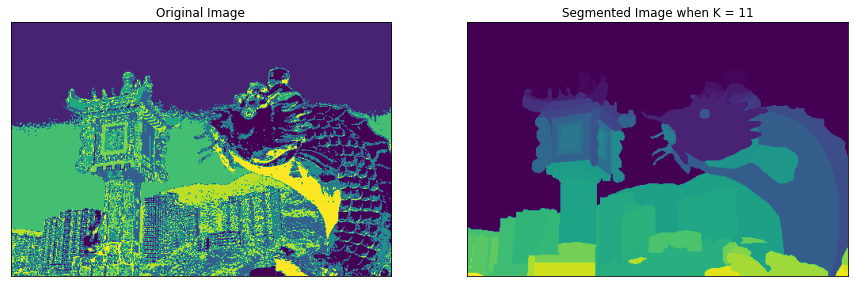

Bad Conditional Entropy


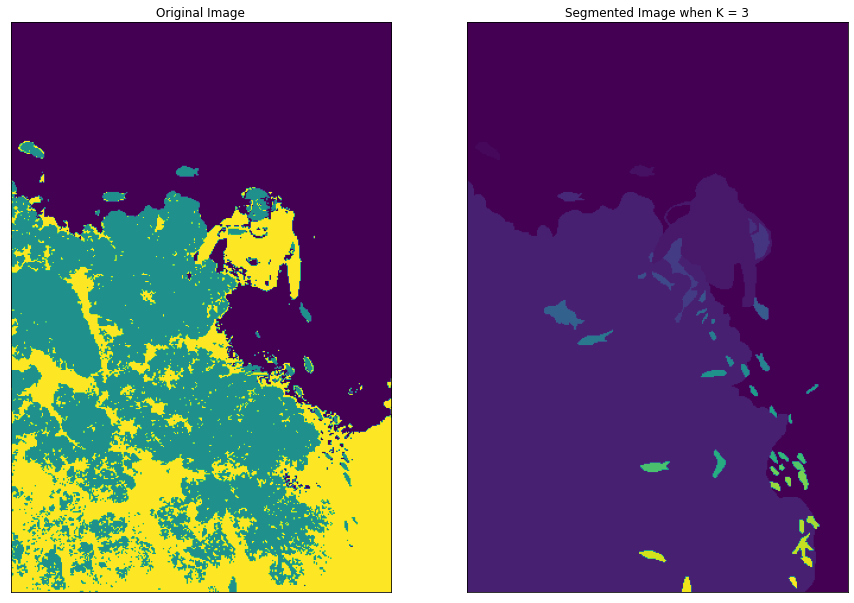

Good F-measure


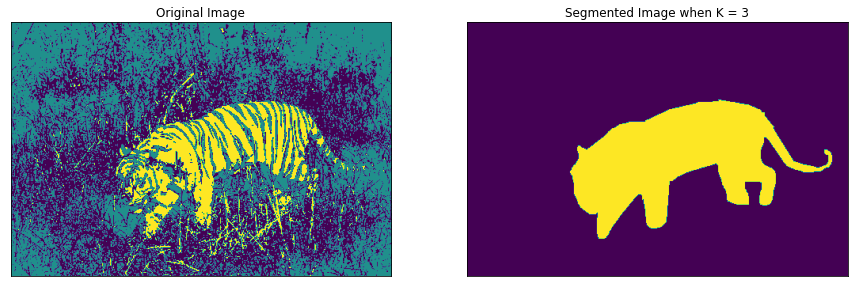

Bad F-measure


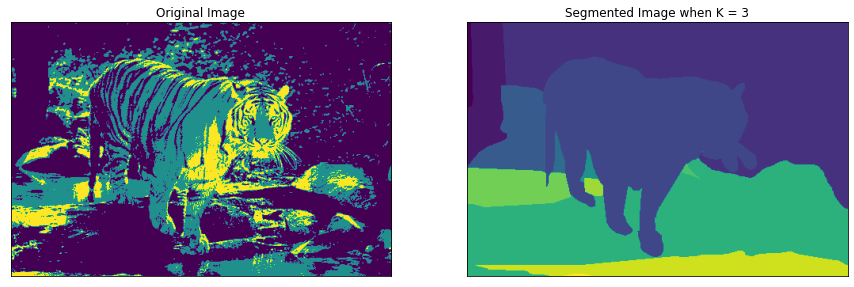

In [65]:

F,C = evaluate(pred_img,ground_truth_testing,K_range) 
      

4.Big picture

In [ ]:
for j in range(5):
    fig, axarr = plt.subplots(2,3, figsize = (20, 8))
    file_name = 'img_' + str(j)
    gt = ground_truth_images_func(j, ground_truth_testing)
    for i in range(6):
        row = i // 3
        col = i % 3
        if i == 0:
            axarr[row][col].imshow(testing_data[j])
        elif i == 1:
           axarr[row][col].imshow(pred_img[j][1]) 
        else:
            axarr[row][col].imshow(gt[i-1], interpolation='nearest')
        fig.suptitle(file_name, fontsize=16)
    plt.show()


In [144]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse import csgraph
from sklearn.cluster import SpectralClustering

In [78]:
# feature = testing_data[0].reshape((-1, 3))
# feature.shape
# img = testing_data[0]

In [79]:
# nn = NearestNeighbors(n_neighbors=400, algorithm='auto')
# nn.fit(feature)
# sim = nn.kneighbors_graph(feature, mode='distance')
# print(feature.shape)
# print(sim.shape)
# print(type(sim))

(154401, 154401)
<class 'scipy.sparse.csr.csr_matrix'>


In [80]:
# sim = radius_neighbors_graph(feature, 0.4, mode='distance', metric='minkowski', p=2, metric_params=None, include_self=False)
# sim.shape

(154401, 154401)

In [81]:
# L = csgraph.laplacian(sim, normed=True)
#eigval = get_eigvecs(L, 5)
# print(L.shape)
# eigval, eigvec = scipy.sparse.linalg.eigs(L, k = 5, sigma=0.000000001)

(154401, 154401)


In [145]:

# km = KMeans(n_clusters=5)
# km.fit(np.real(eigvec))
# seg = km.predict(np.real(eigvec))
# print('done kmean')
# plot_img_seg(img, seg.reshape(img[:, :, 0].shape), 5)

#### Resize the image  

In [83]:
resized_testing = []

In [84]:
i = 0
for img in testing_data:
    scale_percent = 17  # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    resized_testing.append(resized)
    i += 1
    if i == 5:
        break


In [85]:
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(len(resized_testing)):
    shp = resized_testing[i].shape
    img = scaler.fit_transform(resized_testing[i].reshape((-1,3)))
    resized_testing[i] = img.reshape(shp)

In [86]:
resized_testing[1].shape

(54, 81, 3)

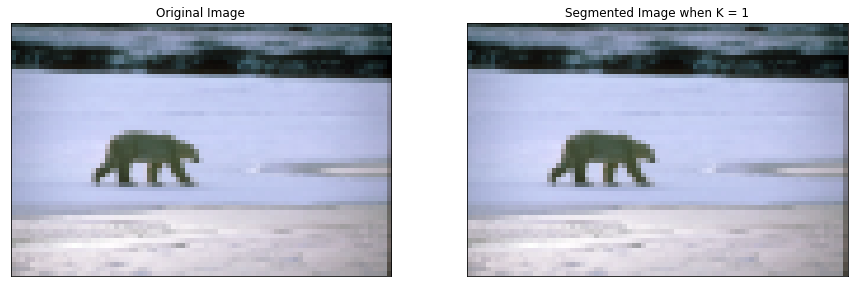

In [87]:
plot_img_seg(resized_testing[0], resized_testing[0], 1)

In [89]:
# def get_eigvecs(L, k):
#     eigvals, eigvecs = np.linalg.eig(L)
#     ix_sorted_eig = np.argsort(eigvals)[:k]
#     return np.real(eigvecs[:,ix_sorted_eig])

In [90]:
# def spectral_clus(sim, k):
#     L = csgraph.laplacian(sim, normed=True)
#     eigvals, eigvecs = np.linalg.eig(L)
#     eigvals = np.real(eigvals)
#     eigvecs = np.real(eigvecs)
#     ix_sorted_eig = np.argsort(eigvals)[:k]
#     return eigvecs[:,ix_sorted_eig]

In [150]:
def nearestrbf(v , k):
    for i in range(v.shape[0]):
        ind = np.argpartition(v[i], -k)[-k:]
        for j in range(v.shape[0]):
            if j not in ind or j == i:
                v[i][j] = 0
    return v

In [154]:
def sp_c(resized_testing, type_eff='nn'):
    j = 0
    spectral_pred = []
    for img in resized_testing:
        feature = img.reshape((-1, 3))
        sim = []
        if type_eff == 'nn150':
            nn = NearestNeighbors(n_neighbors=150, algorithm='auto')
            nn.fit(feature)
            sim = nn.kneighbors_graph(feature, mode='distance')
        elif type_eff == 'rng':
            sim = radius_neighbors_graph(feature, 0.4, mode='distance', metric='minkowski', p=2, metric_params=None, include_self=False)
            sim = sim.toarray()
        elif type_eff == 'kng300':
            sim = kneighbors_graph(feature, 300, mode='distance', metric='minkowski', p=2, metric_params=None, include_self=False)
        elif type_eff == 'nn5':
            nn = NearestNeighbors(n_neighbors=5, algorithm='auto')
            nn.fit(feature)
            sim = nn.kneighbors_graph(feature, mode='distance')
        elif type_eff == 'nn250':
            nn = NearestNeighbors(n_neighbors=250, algorithm='auto')
            nn.fit(feature)
            sim = nn.kneighbors_graph(feature, mode='distance')
        elif type_eff == 'rbf':
            sim = rbf_kernel(feature, gamma=0.1)
        elif type_eff == 'rbf5':
            sim = rbf_kernel(feature, gamma=0.1)
            sim = nearestrbf(sim, 6)
        L = csgraph.laplacian(sim, normed=True)
        eigval, eigvec = scipy.sparse.linalg.eigs(L, k = L.shape[0] - 2)
        eigvec = np.array(eigvec)
        eigvec = np.real(eigvec)
        eigval = np.array(eigval)
        eigval = np.real(eigval)
        idx = eigval.argsort()
        eigval = eigval[idx]
        eigvec = eigvec[:,idx]
        dom_arr = eigvec[:,:5]
        km = KMeans(n_clusters=5)
        km.fit(dom_arr)
        seg = km.predict(dom_arr)
        plot_img_seg(img, seg.reshape(img[:, :, 0].shape), 5)
        spectral_pred.append(seg)
    return spectral_pred

##### 5NearestNeighbors

nn5


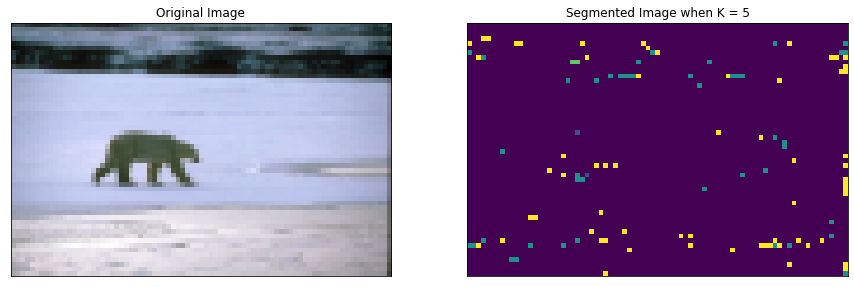

nn5


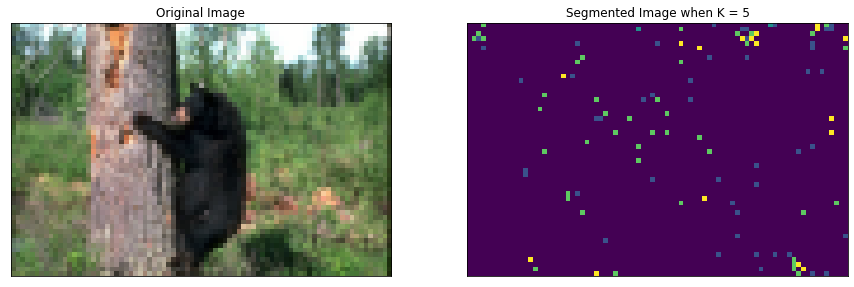

nn5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


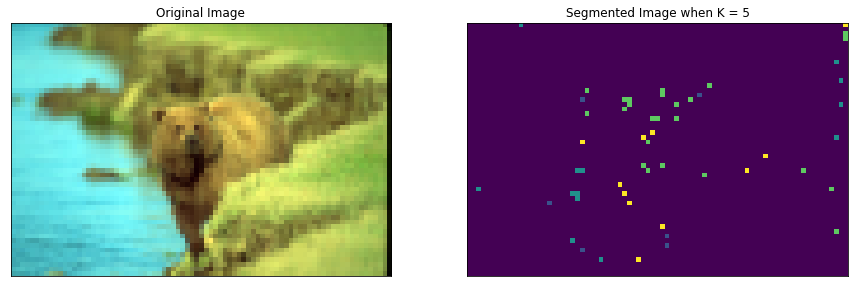

nn5


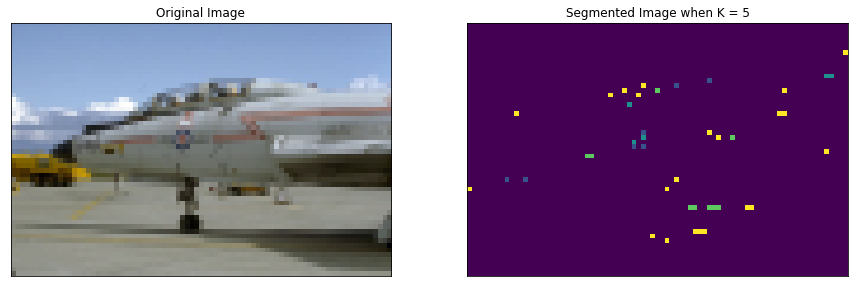

nn5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


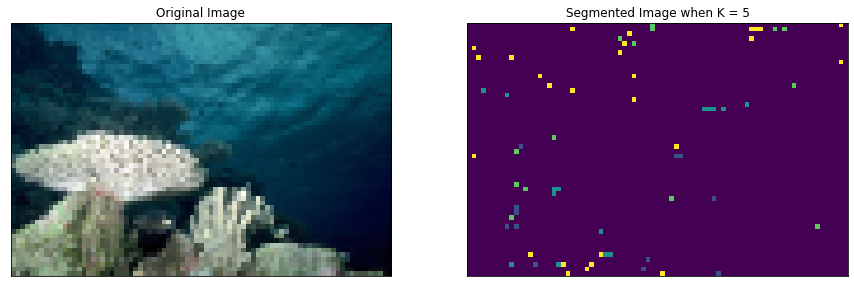

In [93]:
nn5_pred = sp_c(resized_testing=resized_testing, type_eff='nn5')

##### 100NearestNeighbors

nn150


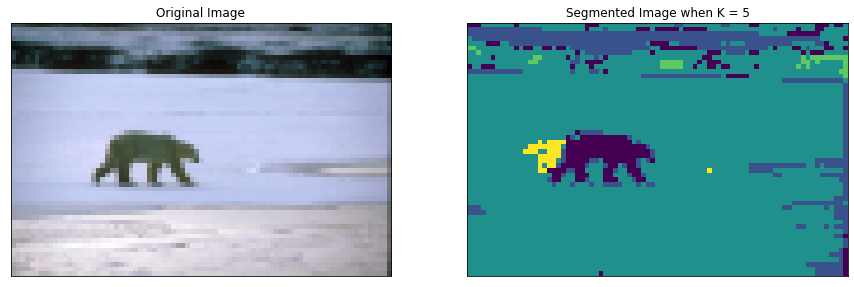

nn150


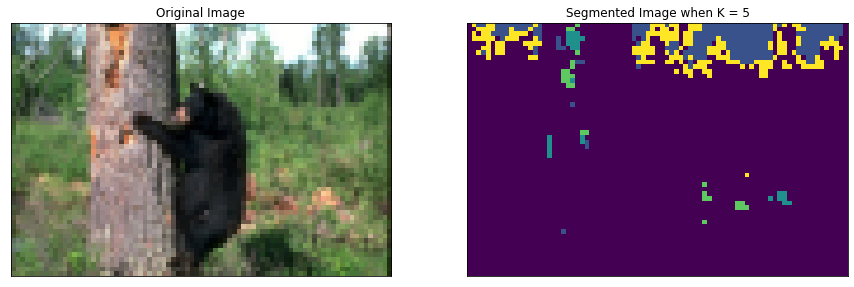

nn150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


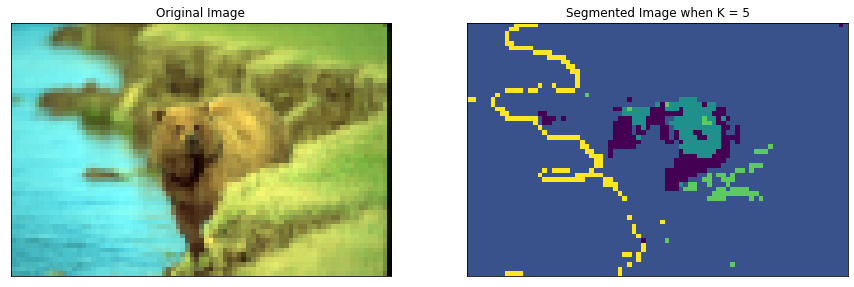

nn150


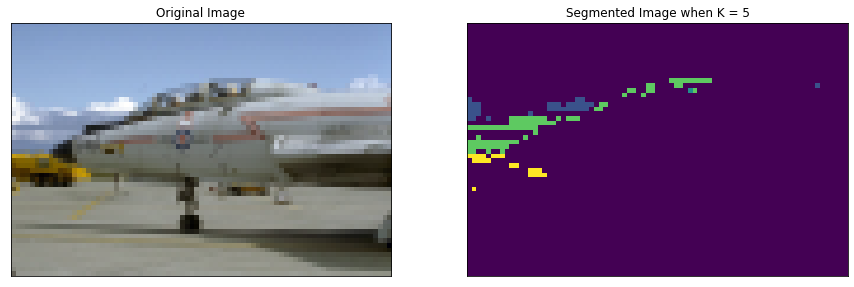

nn150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


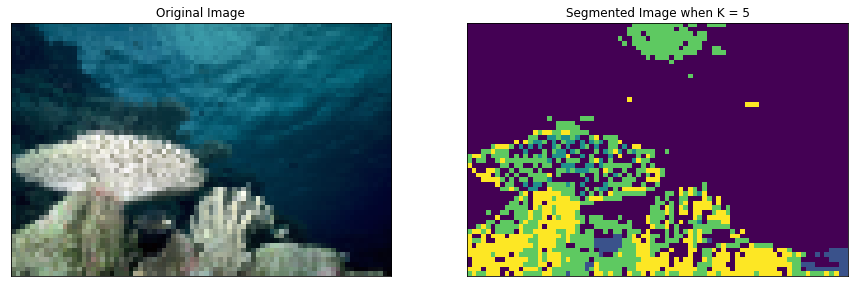

In [95]:
nn100_pred = sp_c(resized_testing=resized_testing, type_eff='nn150')


##### 250NearestNeighbors

nn250


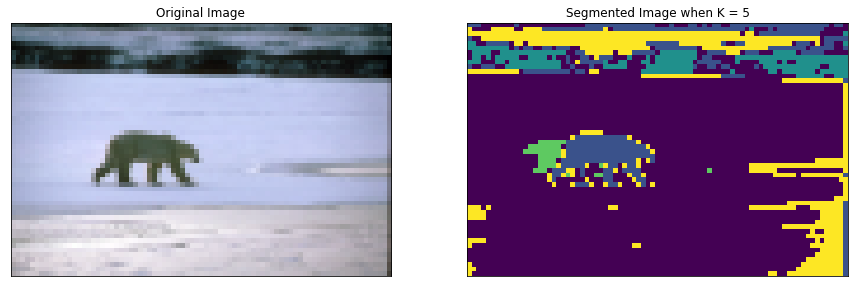

nn250


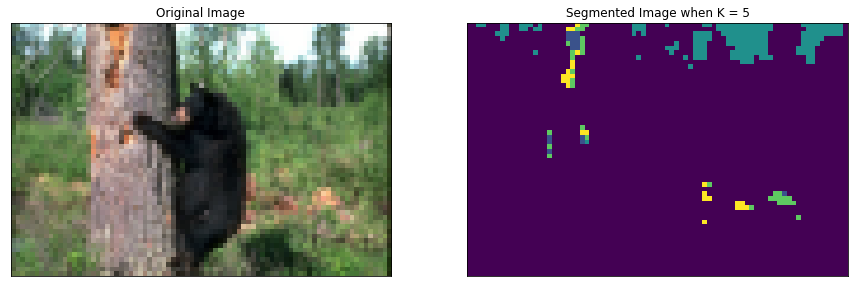

nn250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


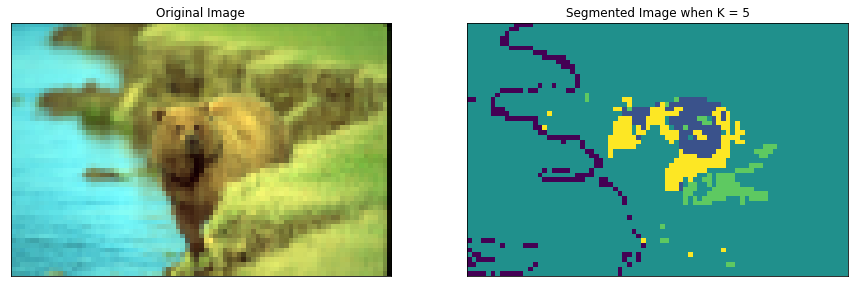

nn250


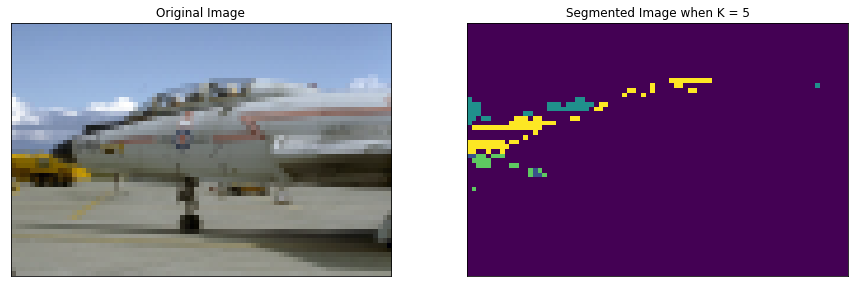

nn250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


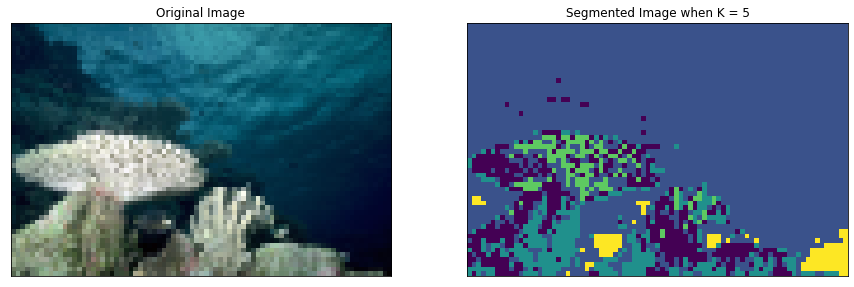

In [96]:
nn250_pred = sp_c(resized_testing=resized_testing, type_eff='nn250')

#### Radius Neighbors Graph

rng


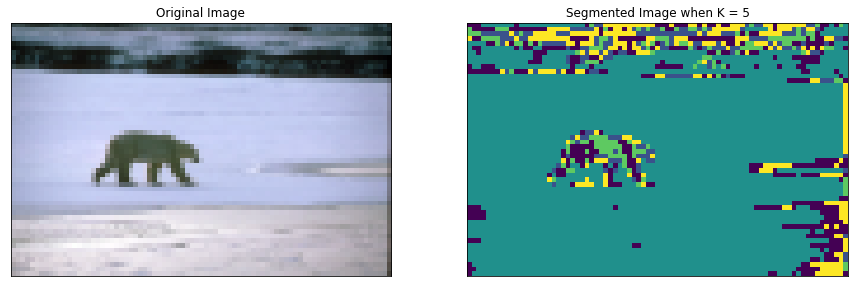

rng


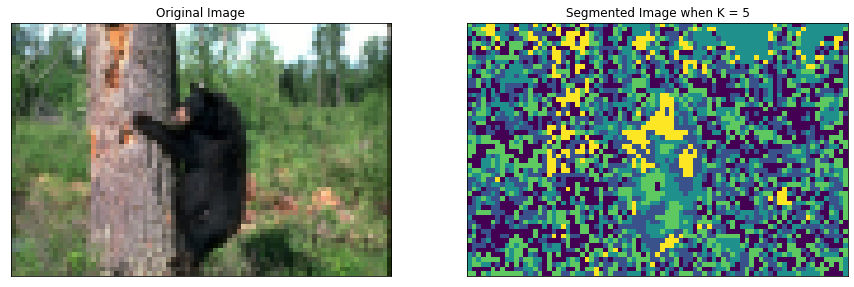

rng


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


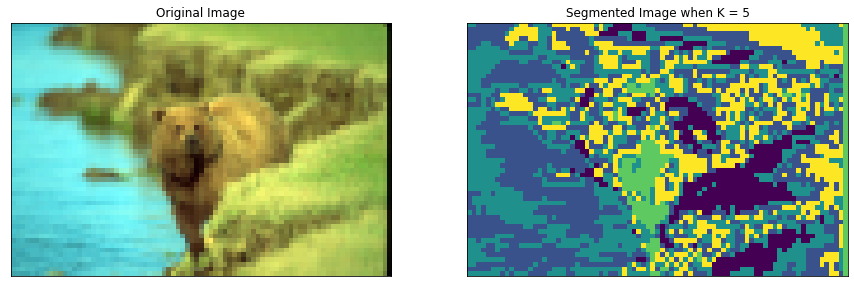

rng


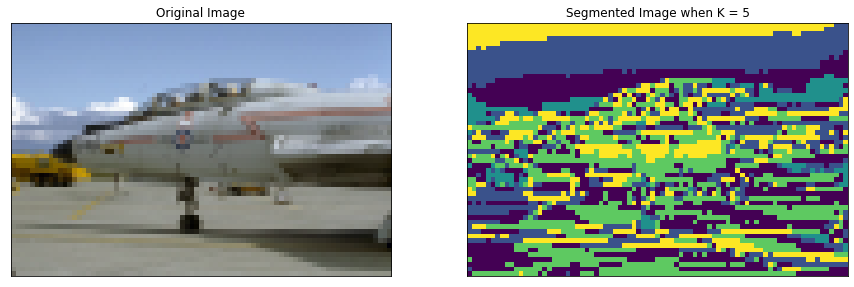

rng


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


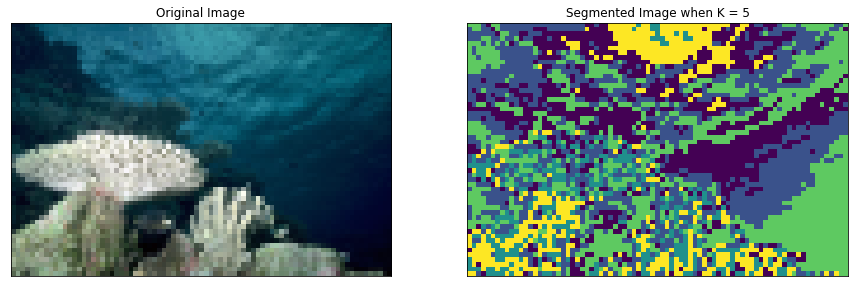

In [97]:
rng_pred = sp_c(resized_testing=resized_testing, type_eff='rng')

#### Kneighbors Graph

kng300


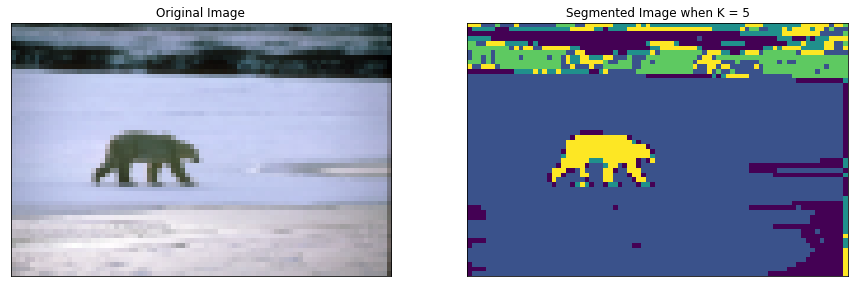

kng300


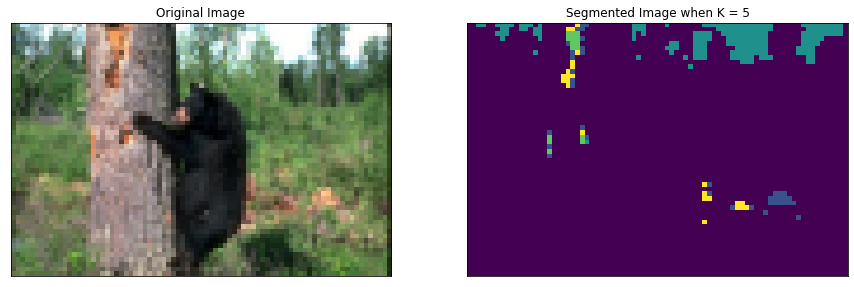

kng300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


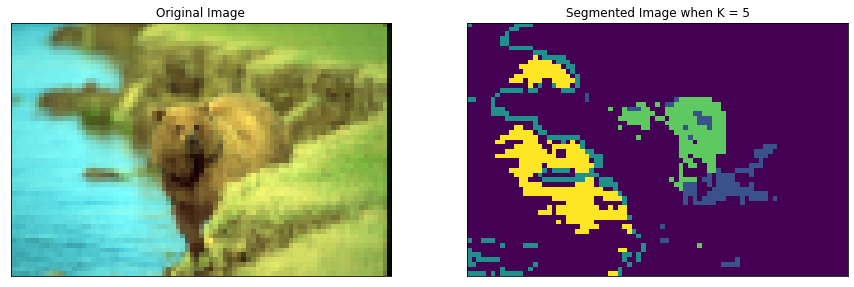

kng300


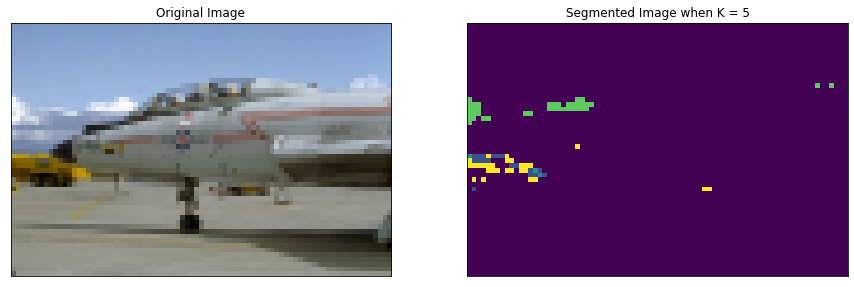

kng300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


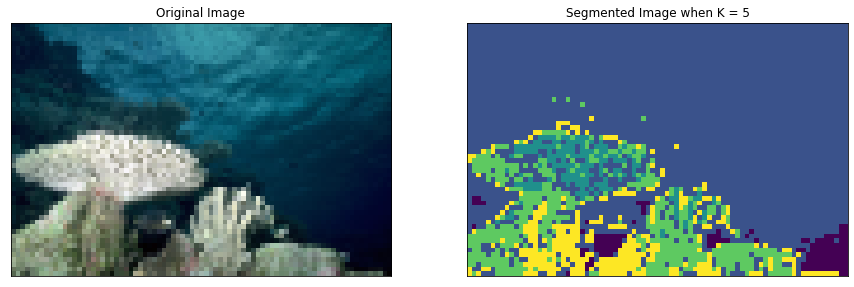

In [143]:
kng250_pred = sp_c(resized_testing=resized_testing, type_eff='kng300')

#### RBF 5 Neighbour

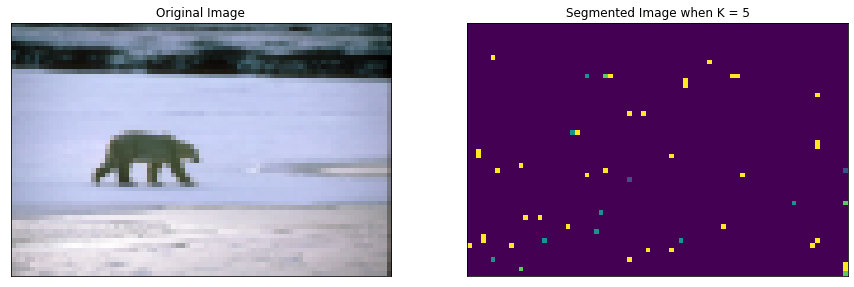

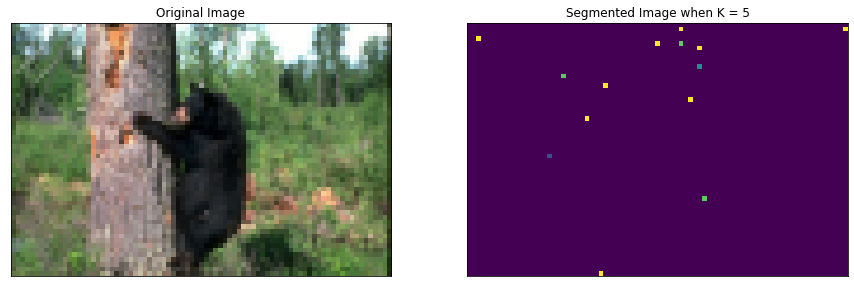

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


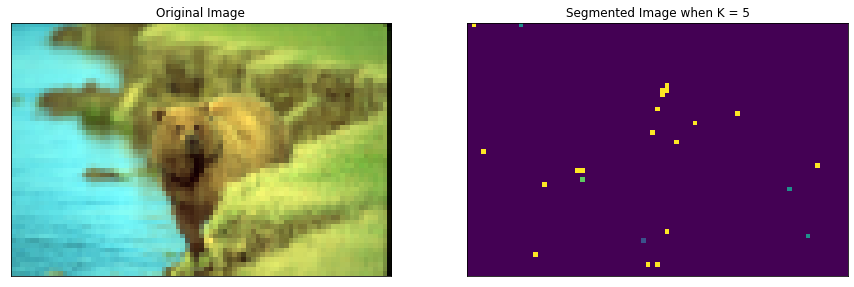

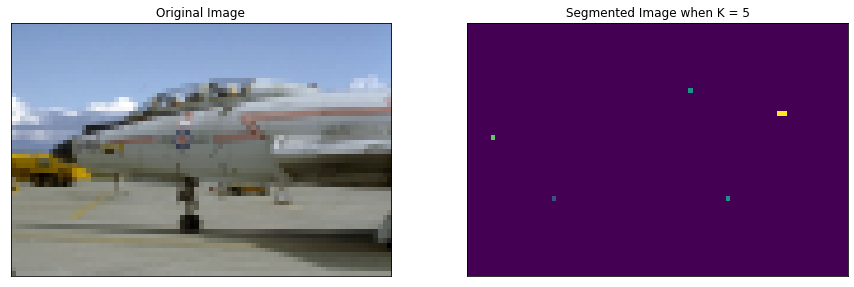

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


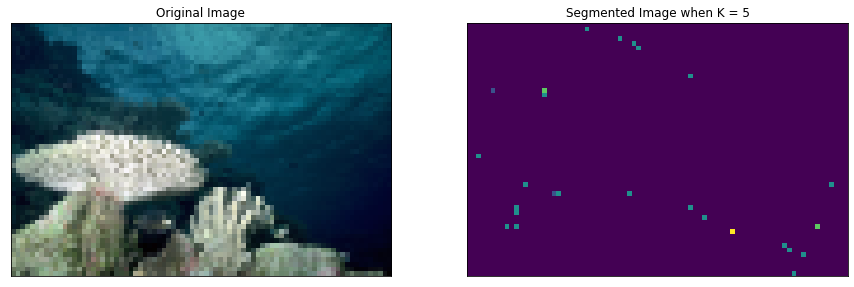

In [152]:
rbf5_pred = sp_c(resized_testing=resized_testing, type_eff='rbf5')

#### RBF Neighbour

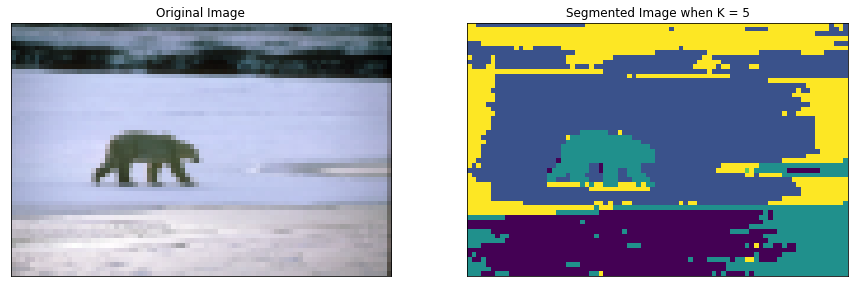

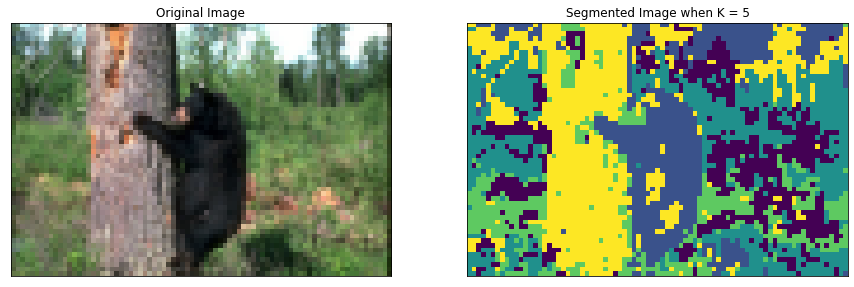

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


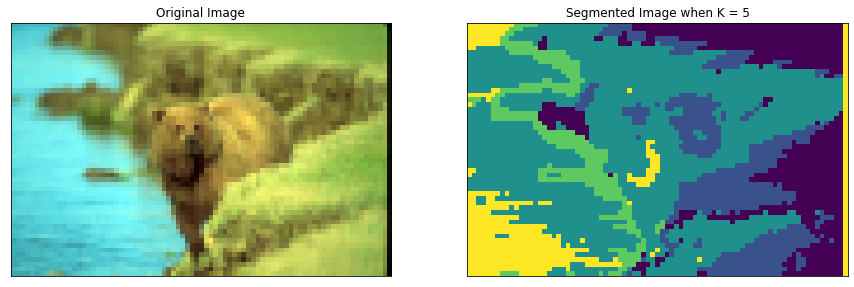

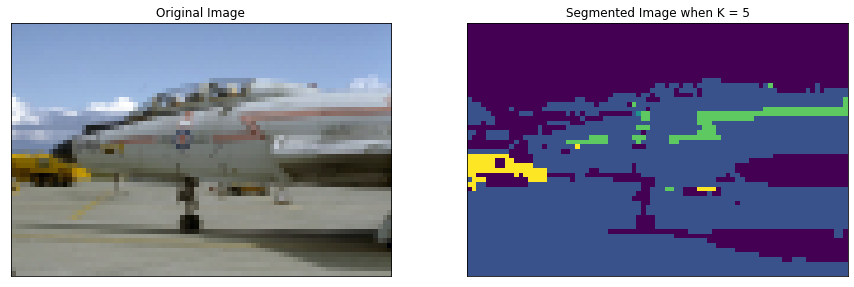

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


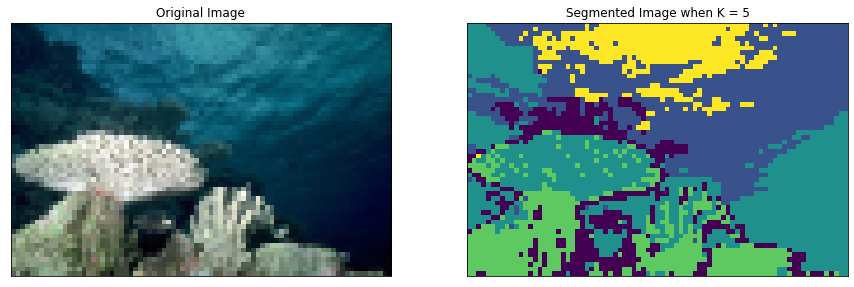

In [153]:
rbf5_pred = sp_c(resized_testing=resized_testing, type_eff='rbf')

In [134]:
# v = rbf_kernel(resized_testing[0].reshape((-1,3)), gamma=0.1)

In [135]:
# for i in range(v.shape[0]):
#     ind = np.argpartition(v[i], -6)[-6:]
#     for j in range(v.shape[0]):
#         if j not in ind or j == i:
#             v[i][j] = 0

In [156]:
# L = csgraph.laplacian(v, normed=True)
# eigval, eigvec = scipy.sparse.linalg.eigs(L, k = L.shape[0] - 2)
# eigvec = np.array(eigvec)
# eigvec = np.real(eigvec)
# eigval = np.array(eigval)
# eigval = np.real(eigval)
# idx = eigval.argsort()
# eigval = eigval[idx]
# eigvec = eigvec[:,idx]
# dom_arr = eigvec[:,:5]
# km = KMeans(n_clusters=5)
# km.fit(dom_arr)
# seg = km.predict(dom_arr)

In [157]:
# plot_img_seg(resized_testing[0], seg.reshape(resized_testing[0][:, :, 0].shape), 5)

In [ ]:
# A = radius_neighbors_graph(resized_testing[0].reshape((-1, 3)),0.4, mode='distance', metric='minkowski', p=2, metric_params=None, include_self=False)
# A = A.toarray()
# A.shape

In [27]:
# from sklearn.neighbors import kneighbors_graph
# aff =  kneighbors_graph(resized_testing[0], 5, mode='distance', include_self=True)

#### SpectralClustering Sklearn

In [103]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=5, n_neighbors=5, gamma=1.0, affinity='rbf',  random_state=0)

In [104]:
sk_cluster = []
for i in range(5):
    sk_cluster.append(clustering.fit_predict(resized_testing[i].reshape((-1, 3))))


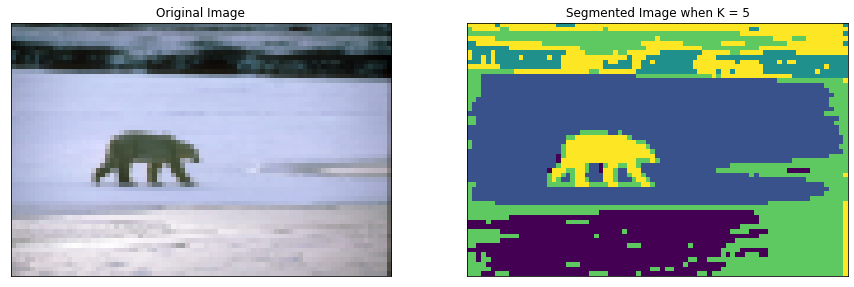

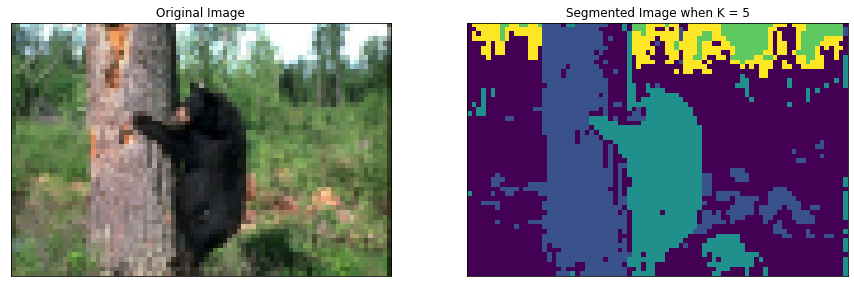

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


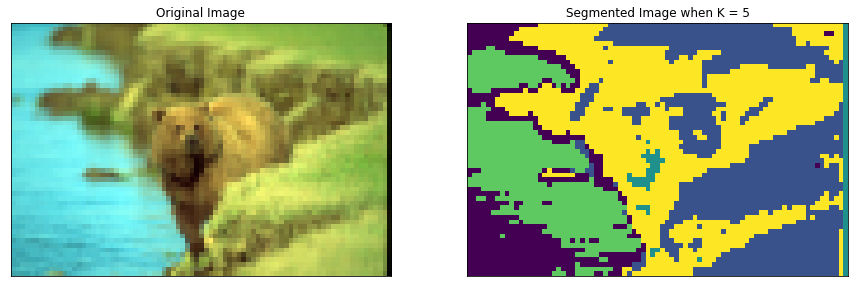

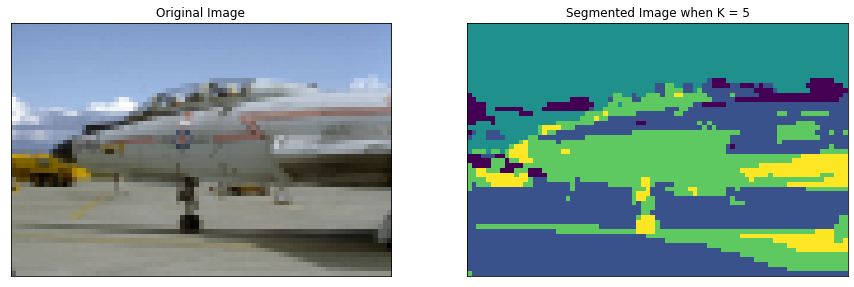

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


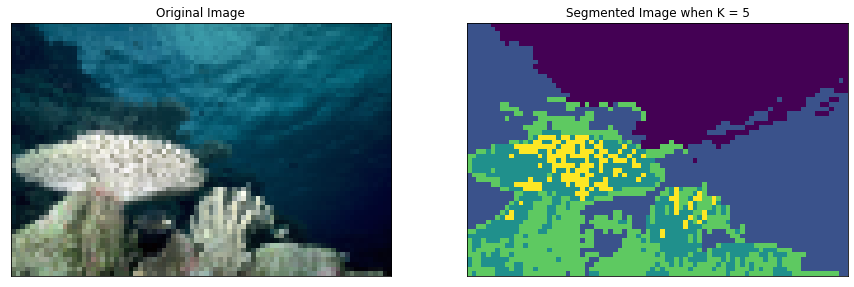

In [105]:
for i in range(5):
    plot_img_seg(resized_testing[i], sk_cluster[i].reshape(resized_testing[i][:, :, 0].shape), 5)

In [106]:
# from sklearn.neighbors import radius_neighbors_graph
# from sklearn.neighbors import kneighbors_graph
# from scipy.sparse import csgraph


In [107]:
# A = radius_neighbors_graph(resized_testing[0].reshape((-1, 3)),0.4,mode='distance', metric='minkowski', p=2, metric_params=None, include_self=False)
# # A = kneighbors_graph(X_mn, 2, mode='connectivity', metric='minkowski', p=2, metric_params=None, include_self=False)
# A = A.toarray()
# A.shape

In [108]:
# L = csgraph.laplacian(A, normed=True)

In [109]:
# def get_eigvecs(L, k):
#     eigvals, eigvecs = np.linalg.eig(L)
#     ix_sorted_eig = np.argsort(eigvals)[:k]
#     return np.real(eigvecs[:,ix_sorted_eig])

In [110]:
# v = get_eigvecs(L, 5)

In [34]:
# # v = np.real(v)
# def kmean_sc(feature, img, k):
#     km = KMeans(n_clusters=k)
#     km.fit(feature)
#     seg = km.predict(feature)
#     seg = seg.reshape((img[:, :, 0].shape))
#     return seg

In [111]:
# km = KMeans(n_clusters=5)

In [112]:
# km.fit(v)
# pre = km.predict(v)

In [113]:
# pre.shape

In [114]:
# plot_img_seg(resized_testing[0], pre.reshape(resized_testing[0][:, :, 0].shape), 5)


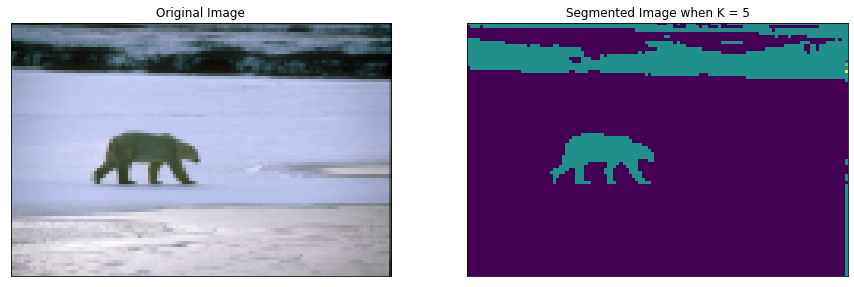

In [52]:
# plot_img_seg(resized_testing[0], pre.reshape(resized_testing[0][:, :, 0].shape), 5)

In [ ]:

# # We use a mask that limits to the foreground: the problem that we are
# # interested in here is not separating the objects from the background,
# # but separating them one from the other.
# mask = testing_data[0].astype(bool)

# img = testing_data[0].astype(float)
# img += 1 + 0.2 * np.random.randn(*testing_data[0].shape)

# # Convert the image into a graph with the value of the gradient on the
# # edges.
# graph = image.img_to_graph(testing_data[0], mask=mask)

# # Take a decreasing function of the gradient: we take it weakly
# # dependent from the gradient the segmentation is close to a voronoi
# graph.data = np.exp(-graph.data / graph.data.std())

# # Force the solver to be arpack, since amg is numerically
# # unstable on this example
# labels = spectral_clustering(graph, n_clusters=5, eigen_solver='arpack')
# label_im = -np.ones(mask.shape)
# label_im[mask] = labels

# plt.matshow(testing_data[0])
# plt.matshow(label_im)

In [ ]:
# def nn_dist(d):
#   sim = np.zeros((d.shape[0], d.shape[0]))
#   for i in range(d.shape[0]):
#     for j in range(d.shape[0]):
#       sim[i][j] = np.linalg.norm(d[i] - d[j])
#   return sim

In [ ]:
# def spectral_graph(d, k, sim_fun , ther=0.7, kn=3, gamma=0.1, q=1):
#   sim = []
#   if q == 1:
#     sim = sim_fun(d, gamma)
#   elif q == 2:
#     sim = sim_fun(d)
#     idx = sim.argsort() 
#     for i in range(sim.shape[0]):
#       for j in range(sim.shape[0]):
#         if j in idx[i][:kn+1] and i != j:
#           sim[i][j] = sim[i][j]
#         else:
#           sim[i][j] = 0
#   deg = np.diag(np.sum(sim, axis=1))
#   print(sim)
#   lap = np.subtract(np.identity(deg.shape[0]), np.dot(np.linalg.inv(deg), sim))
#   eval, evec = np.linalg.eig(lap)
#   idx = eval.argsort()   
#   eigenValues = eval[idx]
#   eigenVectors = evec[:,idx]
#   print(eigenValues)
#   return eigenValues[:k], eigenVectors[:,:k]

In [ ]:
# from skimage.transform import rescale, resize, downscale_local_mean

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# img = scaler.fit_transform(testing_data[0].reshape((-1, 3)))

In [ ]:
# from PIL import Image
# im = Image.fromarray(np.uint8((testing_data[0])))
# # foo = im.resize((100,100),Image.ANTIALIAS)
# # rescale(image, 0.25, anti_aliasing=False)
# im = np.asarray(im)
# im = resize(im, (im.shape[0] // 5, im.shape[1] // 5),
#                        anti_aliasing=True)
# im.shape

In [ ]:
# im.reshape((-1, 3)).shape

In [ ]:
# e, e2 = spectral_graph(im.reshape((-1, 3)), k=5, sim_fun=nn_dist, kn=5, q=2)

In [ ]:
# plot_img_seg(im, im, 5)


In [ ]:
# img = img.reshape(testing_data[0].shape)

In [ ]:
# from skimage import data, color

In [ ]:
# img = testing_data[0]
# img = color.rgb2gray(img)

In [ ]:
# plot_img_seg(img,img,5)

In [ ]:
# img =  rescale(testing_data[0], 0.2)
# img.shape

In [ ]:
# plot_img_seg(img, img, 5)

In [ ]:
# img = img.reshape((-1, 3))
# img.shape

In [ ]:
# mask = img.astype(bool)
# img = img.astype(float)

In [ ]:
# graph = image.img_to_graph(img, mask=mask)

In [ ]:
# graph.shape

In [ ]:
# plot_img_seg(img, img, 1)

In [ ]:
# eval , evec = spectral_graph(im.reshape((-1, 3)), 5, nn_dist, kn=5, q=2)

In [ ]:
# from sklearn.feature_extraction.image import img_to_graph
# graph = img_to_graph(img)

In [ ]:
# graph.shape

In [ ]:
# from sklearn.cluster import SpectralClustering
# clustering = SpectralClustering(n_clusters=5, n_neighbors=5, gamma=1.0, affinity='rbf',  random_state=0).fit_predict(im.reshape((-1, 3)))

In [ ]:
# plot_img_seg(im, clustering.reshape(im[:, :, 0].shape), 5)


In [ ]:
# from sklearn.neighbors import kneighbors_graph
# aff =  kneighbors_graph(im.reshape((-1, 3)), 5, mode='distance', include_self=True)

In [ ]:
# from sklearn.cluster import spectral_clustering
# labels = spectral_clustering(aff, n_clusters=5)

In [ ]:
# km = KMeans(n_clusters=5)
# km.fit(labels.reshape((-1,1)))
# pre = km.predict(labels.reshape((-1,1)))

In [ ]:
# plot_img_seg(im, pre.reshape(im[:, :, 0].shape), 5)


In [155]:
# aff.shape

In [ ]:
# from scipy.sparse import csgraph

In [ ]:
# l = csgraph.laplacian(aff, normed=False)

In [ ]:
# l.shape

In [ ]:
# eval, evec = scipy.sparse.linalg.eigsh(l, k=5, sigma=0.0000000001)

In [ ]:
# km = KMeans(n_clusters=5)
# km.fit(evec)
# pre = km.predict(evec)

In [ ]:
# pre.shape

In [ ]:
# np.sum(pre)

In [ ]:
# from collections import Counter
# Counter(km.labels_)

In [ ]:
# (img[:, :, 0].shape)

In [ ]:
# plot_img_seg(im, pre.reshape(im[:, :, 0].shape), 5)

In [ ]:
# plot_img_seg(testing_data[0], pre.reshape(testing_data[0][:, :, 0].shape), 5)

In [ ]:
# label_im = -np.ones(mask.shape)
# label_im[mask] = labels

# plt.matshow(testing_data[0])
# plt.matshow(label_im)

In [ ]:
# graph_laplacian = generate_graph_laplacian(testing_data[2].reshape((-1, 3))[0:11877, :], 5)

In [ ]:
# labels = spectral_clustering(testing_data[0].reshape((-1, 3)), n_clusters=5, eigen_solver='arpack')

In [ ]:
# spectral_clustering = SpectralClustering(n_clusters=5, n_neighbors=5, random_state=0, assign_labels='kmeans')

In [ ]:
# testing_data[0].shape

In [ ]:
# t = testing_data[0].reshape((-1, 3))
# print(t.shape)


In [ ]:
# part_1 = t[0:51467, :]
# part_2 = t[51467:51467+51467, :]
# part_3 = t[51467+51467:154401, :]
# print(part_1.shape)
# print(part_2.shape)
# print(part_3.shape)

In [ ]:
# spectral_clustering.fit(t)

In [ ]:
# path='./content/output/Result'
# ind_name = 0
# pred_img = []
# for test_img in testing_data:
#     image_list = []
#     fig, axarr = plt.subplots(2,3, figsize = (15, 15))
#     file_name = 'img_' + str(ind_name)
#     image_list.append(test_img)
#     for k in K_range:
#         image_list.append(kmean_f(test_img, k))
#     pred_img.append(image_list[1:])
#     for i in range(len(image_list)):
#         row = i // 3
#         col = i % 3
#         if i == 0:
#             axarr[row][col].imshow(image_list[0])
#         axarr[i // 3][i % 3].imshow(image_list[i], interpolation='nearest')
    
#     fig.suptitle(file_name, fontsize=16)
#     plt.savefig(os.path.join(path, file_name), bbox_inches = 'tight')
#     plt.close(fig)
#     ind_name += 1 

# 5. Extra